In [1]:
#please install the following packages before running the code
# pip install keras-unet-collection
# pip install tensorflow
# pip install numpy
# pip install matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import sklearnd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from keras_unet_collection import models

In [3]:
#is gpu available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


GPU is available


#This is the U-net model  just for refrence
Attention U-net is applied for this segmentation task. 



U-net for binary classification with:

Five down- and upsampliung levels (or four downsampling levels and one bottom level).

Two convolutional layers per downsampling level.

One convolutional layer (after concatenation) per upsamling level.

Gaussian Error Linear Unit (GELU) activcation, Softmax output activation, batch normalization.

Downsampling through Maxpooling.

Upsampling through reflective padding.

In [4]:
model_unet = models.unet_2d((128, 128, 1), [64, 128, 256, 512, 1024], n_labels=2,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax',
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

In [5]:
model_unet.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=1e-2))

Attention U-net is applied for this segmentation task. 
This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level.

Attention-Unet Attention-Unet for binary classification:

Four down- and upsampling levels.

Two convolutional layers per downsampling level.

Two convolutional layers (after concatenation) per upsampling level.

ReLU activation, linear output activation (None), batch normalization.

Additive attention, ReLU attention activation.

Downsampling through stride convolutional layers.

In [6]:
model = models.att_unet_2d((128, 128, 1), filter_num=[64, 128, 256, 512, 1024], n_labels=2,
                           stack_num_down=2, stack_num_up=2, activation='ReLU',
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           #@backbone='VGG16', weights='imagenet',
                           #freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=1e-2))

In [8]:
#just load in memmory the data for training the model
#swap the axes
train=np.load('./data/train_np.npy')
train=np.swapaxes(train,2,0)
train=np.swapaxes(train,2,1)
label=np.load('./data/label_np.npy')
label=np.swapaxes(label,2,0)
label=np.swapaxes(label,2,1)


This data is composed of 4000 seismic images (one channel)  with fault labels

In [9]:
print(train.shape)
print(label.shape)

(4000, 128, 128)
(4000, 128, 128)


In [10]:
def plot_seis(n):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(train[n],cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(label[n],cmap='gray')
    plt.show()


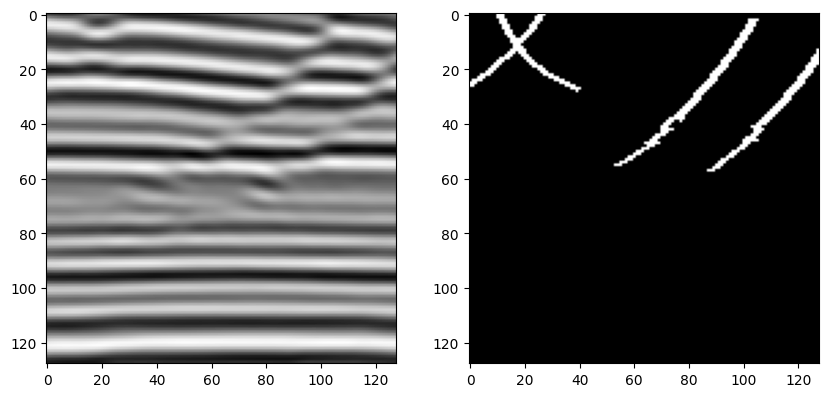

In [11]:
#plot a sample image and its corresponding label
n=10 #(n<4000)
plot_seis(n)

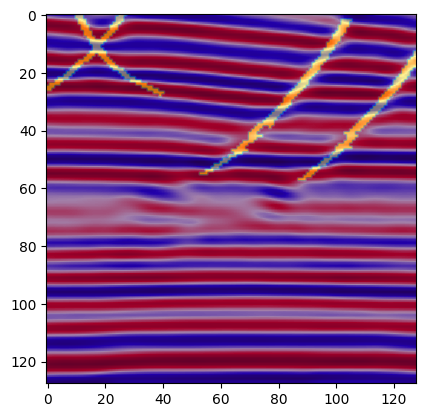

In [12]:
#plot train[0]  label[0]  and overlay
import matplotlib.pyplot as plt
plt.imshow(train[n],cmap='seismic')
plt.imshow(label[n],alpha=0.5)
plt.show()


In [13]:
#normalize the data
print(train.max(),train.min())
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_nor= scaler.fit_transform(train.reshape(-1,1)).reshape(train.shape)

0.6187025308609009 -0.6366393566131592


In [14]:
print(train_nor.shape)
train_nor.max(),train_nor.min()

(4000, 128, 128)


(1.0, 0.0)

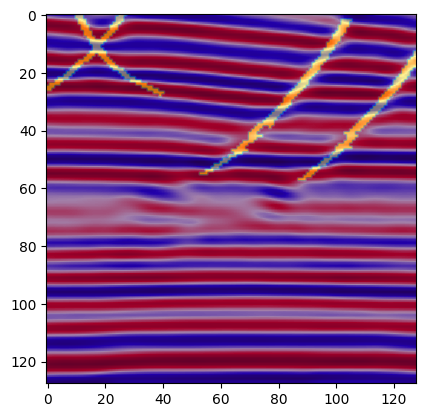

In [15]:
#plot train  label  and overlay
#the image is normalized and the label is not
import matplotlib.pyplot as plt
plt.imshow(train_nor[n],cmap='seismic')
plt.imshow(label[n],alpha=0.5)
plt.show()


In [16]:
#we have to convert the label to categorical
def target_data_process(target_array):
    '''Converting faults, non-faults pixels into two categories.'''
    target_array[target_array>0]=1 # grouping all other non-faults categories
    return keras.utils.to_categorical(target_array, num_classes=2)

In [17]:
label_cl=target_data_process(label)

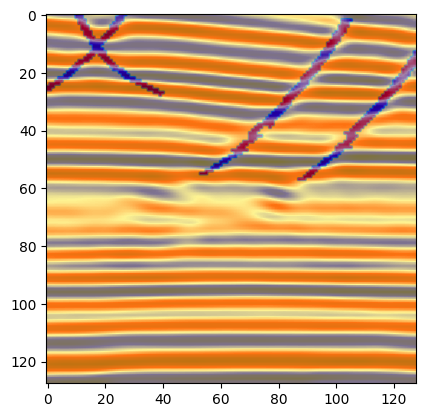

In [18]:
#plot train[0]  label[0]  and overlay
import matplotlib.pyplot as plt
plt.imshow(train[n],cmap='seismic')
plt.imshow(label_cl[n,:,:,0],alpha=0.5)
plt.show()


In [49]:
#preapare the train data for the model
train_data=np.zeros((4000,128,128,1))
label_data=np.zeros((4000,128,128,2))
for i in range(4000):
    train_data[i,:,:,0]=train_nor[i,:,:]
    label_data[i]=label_cl[i]
    

In [50]:
print(train_data.shape)
print(label_data.shape)

(4000, 128, 128, 1)
(4000, 128, 128, 2)


this is the dimension of the data an lable for the model 

In [21]:
#we have 40000 images, we can use 3600 for training and 400 for validation
# number of epochs is 20, but try more epochs to see if the model is learning (e.g. 100)
#batch size is 8, but try different batch sizes (e.g. 16, 32, 64)
#train the model
#loss is decreasing and the accuracy is increasing
model.fit(train_data[0:3600],label_data[0:3600],batch_size=8,epochs=20,validation_data=(train_data[3600:],label_data[3600:]))

Epoch 1/20
450/450 [==============================] - 32s 64ms/step - loss: 0.1306 - val_loss: 0.0893
Epoch 2/20
450/450 [==============================] - 29s 65ms/step - loss: 0.0843 - val_loss: 0.0868
Epoch 3/20
450/450 [==============================] - 30s 66ms/step - loss: 0.0826 - val_loss: 0.0856
Epoch 4/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0812 - val_loss: 0.0839
Epoch 5/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0797 - val_loss: 0.0821
Epoch 6/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0778 - val_loss: 0.0802
Epoch 7/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0760 - val_loss: 0.0790
Epoch 8/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0738 - val_loss: 0.0764
Epoch 9/20
450/450 [==============================] - 31s 70ms/step - loss: 0.0715 - val_loss: 0.0731
Epoch 10/20
450/450 [==============================] - 32s 71ms/step - loss: 0.068

In [51]:
validation_data=train_data[3600:].reshape(400,128,128,1)
validation_label=label_data[3600:].reshape(400,128,128,2)

In [52]:
eval=model.evaluate(validation_data,validation_label)

13/13 [==============================] - 1s 71ms/step - loss: 0.0765


In [53]:
print("Evaluation loss",eval)   

Evaluation loss 0.07648637145757675


In [39]:
#predict the output for a sample image
i=100 #sample image (i<400)

input_img=validation_data[i,:,:,0].reshape(1,128,128,1) #reshape the input image
label_img=validation_label[i,:,:,:].reshape(1,128,128,2) #reshape the label image
pred_img=model.predict(input_img) #predict the output
#check the shapes of the input, label and predicted images
print(input_img.shape,label_img.shape ,pred_img.shape)


1/1 [==============================] - 0s 16ms/step


(1, 128, 128, 1) (1, 128, 128, 2) (1, 128, 128, 2)


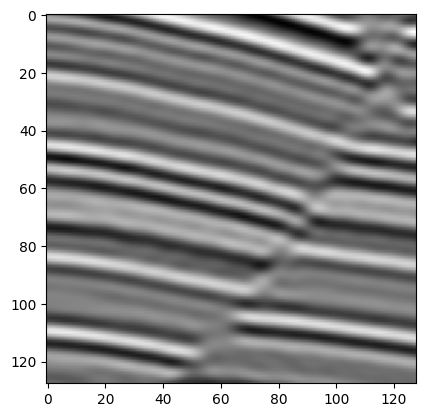

In [40]:
#plot the original image, label and the predicted image
plt.imshow(input_img[0],cmap='gray')
plt.show()


(1, 128, 128, 2)


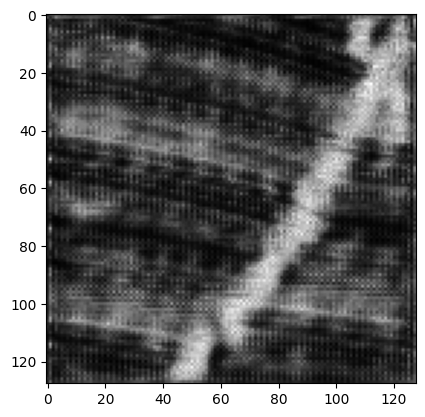

In [41]:
print(pred_img.shape)
#plot the output
plt.imshow(pred_img[0,:,:,1],cmap='gray')
plt.show()


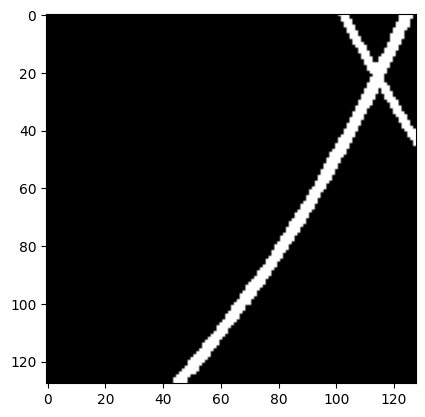

In [42]:
plt.imshow(label_img[0,:,:,1],cmap='gray')
plt.show()

#

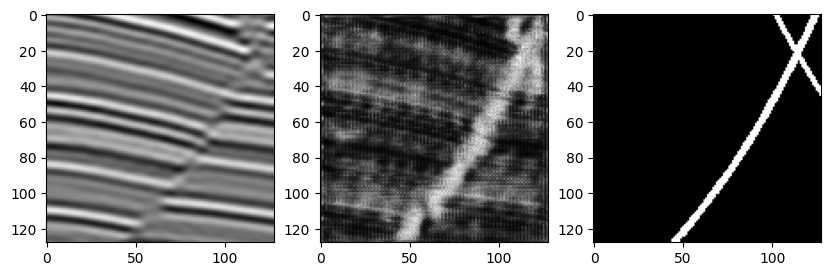

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(input_img[0],cmap='gray')
plt.subplot(2,3,2)
plt.imshow(pred_img[0,:,:,1],cmap='gray')
plt.subplot(2,3,3)
plt.imshow(label_img[0,:,:,1],cmap='gray')
plt.show()

In [46]:
#train using unet model (with  no attention)
#this training is similar to the above training
#the model is different
model_unet.fit(train_data[0:3600],lable_data[0:3600],batch_size=8,epochs=20,validation_data=(train_data[3600:],lable_data[3600:]))

Epoch 1/20
450/450 [==============================] - 29s 65ms/step - loss: 0.0537 - val_loss: 0.0545
Epoch 2/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0513 - val_loss: 0.0529
Epoch 3/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0494 - val_loss: 0.0514
Epoch 4/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0479 - val_loss: 0.0503
Epoch 5/20
450/450 [==============================] - 30s 68ms/step - loss: 0.0465 - val_loss: 0.0492
Epoch 6/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0451 - val_loss: 0.0482
Epoch 7/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0439 - val_loss: 0.0471
Epoch 8/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0428 - val_loss: 0.0467
Epoch 9/20
450/450 [==============================] - 30s 67ms/step - loss: 0.0418 - val_loss: 0.0460
Epoch 10/20
450/450 [==============================] - 30s 67ms/step - loss: 0.040

In [47]:
pred_img_unet=model_unet.predict(input_img) #predict the output

1/1 [==============================] - 0s 63ms/step


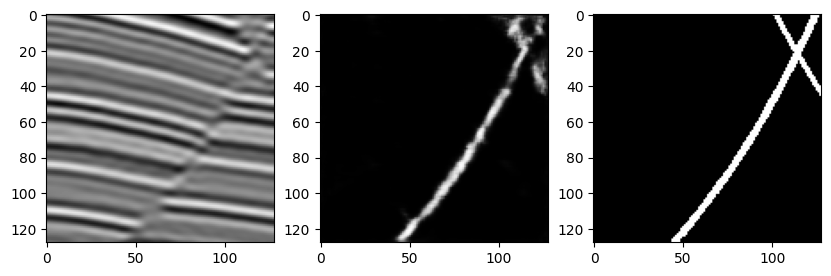

In [48]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(input_img[0],cmap='gray')
plt.subplot(2,3,2)
plt.imshow(pred_img_unet[0,:,:,1],cmap='gray')
plt.subplot(2,3,3)
plt.imshow(label_img[0,:,:,1],cmap='gray')
plt.show()